# Comparaison des approches implémentées pour le calcul de la décomposition en k-core d'un graph

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

## Approche naive

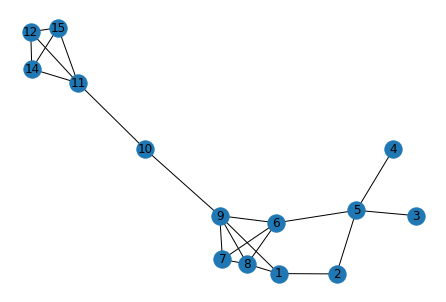

In [4]:
g = nx.Graph([])
g.add_edges_from([(1,2),(1,8),(1,9),
                  (5,2),
                  (5,3),
                  (5,4),
                  (5,6),
                  (6,7),
                  (6,8),
                  (6,9),
                  (7,8),
                  (7,9),
                  (8,9),
                  (9,10),
                  (10,11),
                  (11,14),
                  (11,15),
                  (11,12),
                  (14,15),
                  (15,12),
                  (12,14)
                 ])
nx.draw(g,with_labels=True)
plt.show()

In [5]:
def approche_naive(g):
    gg = copy.deepcopy(g)
    weights = dict(gg.degree)

    cores_g = dict(zip(gg.nodes,[0]*len(gg.nodes)))

    while len(gg.nodes) > 0:
        index_top , min_degree   = min(weights.items(), key=itemgetter(1))
        neighbors = list(gg.neighbors(index_top))
        cores_g[index_top] = min_degree
        gg.remove_node(index_top)
        weights.pop(index_top)

        if neighbors:
            new_degrees=gg.degree()
            for neigh in neighbors:
                weights[neigh] = max(min_degree,new_degrees[neigh])
                
    return cores_g

## Approche semi-naive 

In [6]:
def batagelj_naif(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

In [7]:
%load_ext Cython

In [8]:
%%cython
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

def batagelj_naif_cython(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

## Approche NetworkX

In [9]:
def batagelj_avance(G):
# inspiré, comme mentionné sur le rapport, du code source de NetworkX, (Hagberg, Schult, Swart)
    degrees = dict(G.degree())
    # Sort nodes by degree.
    nodes = sorted(degrees, key=degrees.get)
    bin_boundaries = [0]
    curr_degree = 0
    for i, v in enumerate(nodes):
        if degrees[v] > curr_degree:
            bin_boundaries.extend([i] * (degrees[v] - curr_degree))
            curr_degree = degrees[v]
    node_pos = {v: pos for pos, v in enumerate(nodes)}
    

    core = degrees
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    for v in nodes:
        for u in nbrs[v]:
            if core[u] > core[v]:
                nbrs[u].remove(v)
                pos = node_pos[u]
                bin_start = bin_boundaries[core[u]]
                node_pos[u] = bin_start
                node_pos[nodes[bin_start]] = pos
                nodes[bin_start], nodes[pos] = nodes[pos], nodes[bin_start]
                bin_boundaries[core[u]] += 1
                core[u] -= 1
    return core

### Sanity check

On teste que nos approches soient bonnes sur un nombre suffisament important et divers de graphes

In [10]:
G = nx.duplication_divergence_graph(10**3,0.7)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [11]:
G = nx.balanced_tree(5,3)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [12]:
G = nx.circular_ladder_graph(150)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [13]:
G = nx.generators.random_graphs.gnm_random_graph(150,200)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

## Approches parallélisées

### Approche 1 : multithreading avec Python

In [14]:
from threading import Thread, Lock

N_THREADS = 10

In [15]:
# L'algorithme PKC fonctionne en mettant à jour itérativement et en parallèle
# le dictionnaire des degrés des noeuds.
# Afin de le protéger d'éventuelles race conditions, on protège sa lecture et son écriture
# en l'encapsulant dans une classe et en implémentant des threadlocks.
# On fait de même pour la variable visited qui donne le critère d'arrêt de l'algorithme.

class Counters():
    """Encapsule les compteurs dans une classe avec des threadlocks pour éviter les race conditions."""
    def __init__(self, G):
        G = G.copy()
        self.deg = dict(G.degree)
        self.visited = 0
        self.lock = Lock()

    def get_degree(self, node):
        with self.lock:
            return self.deg[node]

    def increment_degree(self, node, value):
        with self.lock:
            self.deg[node] += value
            return self.deg[node]

    def get_visited(self):
        with self.lock:
            return self.visited

    def increment_visited(self, value):
        with self.lock:
            self.visited += value

    def reinitialize(self, G):
        self.visited = 0
        self.deg = dict(G.degree)

In [16]:
def process_nodes_multithread(nodes_ind, G, counters, level):
    """Traite une séquence de noeuds de manière local sur un thread."""
    nodes_list = list(G.nodes)
    buff = np.zeros_like(nodes_list).astype(int)
    start = 0
    end = 0
    
    # On stocke les noeuds qui doivent être traités (i.e. tq current core == level)
    # dans un buffer local à chaque thread
    for i in nodes_ind:
        deg_i = counters.get_degree(nodes_list[i])
        if deg_i == level:
            buff[end] = i
            end += 1
    
    # Chaque thread traite séquentiellement les noeuds de son buffer en comparant
    # les degrés de ses voisins au niveau d'entrée (level)
    while start < end:
        v = buff[start]
        start += 1
        for u in G.neighbors(nodes_list[v]):
            if counters.get_degree(u) > level:
                a = counters.increment_degree(u, -1)
                if a == level:
                    buff[end] = nodes_list.index(u)
                    end += 1
                if a < level:
                    counters.increment_degree(u, 1)

    counters.increment_visited(end)

In [17]:
def pkc_multithread(G):
    """Calcule une décomposition en K-core en parallélisant le traitement sur des threads."""
    G = G.copy()
    n = len(G.nodes)
    assert(N_THREADS < n)
    counters = Counters(G)

    nodes_split = np.array_split(range(n), N_THREADS)
    level = 0
    visited = 0
    thread_list = []
    
    # On traite des blocs de noeuds de taille n / n_threads en parallèle
    while visited < n:
        for t in range(N_THREADS):
            thread = Thread(target=process_nodes_multithread, 
                            args=(nodes_split[t], G, counters, level))
            thread_list.append(thread)
            thread_list[t].start()
        for thread in thread_list:
            thread.join()
        thread_list = []

        level += 1
        visited = counters.get_visited()

    deg = counters.deg.copy()

    return deg

In [18]:
# Sanity check
assert(nx.core_number(g) == pkc_multithread(g))

## Approche 2 : multiprocessing avec Python

In [19]:
from multiprocessing import Process, Value, Array, cpu_count

N_PROCESSES = cpu_count()

In [20]:
def process_nodes_multiprocess(nodes_ind, G, deg, visited, level):
    """Process a sequence of nodes on a local process."""
    nodes_list = list(G.nodes)
    buff = np.zeros_like(nodes_list).astype(int)
    start = 0
    end = 0

    for i in nodes_ind:
        deg_i = deg[i]
        if deg_i == level:
            buff[end] = i
            end += 1

    while start < end:
        v = buff[start]
        start += 1
        for u in G.neighbors(nodes_list[v]):
            ind_u = nodes_list.index(u)
            if deg[ind_u] > level:
                deg[ind_u] -= 1
                if deg[ind_u] == level:
                    buff[end] = ind_u
                    end += 1
                if deg[ind_u] < level:
                    deg[ind_u] += 1

    visited.value += end

In [21]:
def pkc_multiprocess(G):
    """Perform multiprocessing K-core decomposition."""
    G = G.copy()
    nodes = list(G.nodes)
    n = len(nodes)
    nodes_split = np.array_split(range(n), N_PROCESSES)

    deg = Array('i', list(dict(G.degree).values()))
    visited = Value('i', 0)
    level = 0

    process_list = []

    while visited.value < n:
        for t in range(N_PROCESSES):
            process = Process(target=process_nodes_multiprocess, 
                              args=(nodes_split[t], G, deg,
                                    visited, level))
            process_list.append(process)
            process_list[t].start()
        for process in process_list:
            process.join()
        process_list = []

        level += 1

    kcore = {nodes[i]: deg[i] for i in range(n)}

    return kcore

In [22]:
# Sanity check
assert(nx.core_number(g) == pkc_multiprocess(g))

## Approche 3 : multithreading avec Cython + OpenMP

In [23]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [24]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import numpy as np
from cython.parallel import parallel, prange,  threadid
from libc.stdlib cimport abort, malloc, free
cimport cython, openmp

DTYPE = np.intc
cdef int NUM_THREADS = 10

@cython.boundscheck(False)
def pkc_cython(int[:] deg, int[:] deg_init, int[:, :] neighbors):

    # C externals for sync threads + increment/decrement
    cdef extern int __sync_fetch_and_sub (int *deg_node, int decrement) nogil
    cdef extern int __sync_fetch_and_add (int *deg_node, int increment) nogil

    # global variables
    cdef:
        int n = deg.shape[0]
        int visited = 0
        Py_ssize_t n_neighbors
        int max_neighbors = neighbors.shape[1]

    # declare thread local variables pointers
    cdef:
        int *buff
        int *v
        int *n_neighbors_v
        int *deg_u
        int *start
        int *end
        int *level
        Py_ssize_t i, j, u


    # start parallelization over thread with released GIL
    with nogil, parallel():

        # declare thread local variables
        buff = <int *> malloc(sizeof(int)*n//NUM_THREADS) # Local buffer
        v = <int *> malloc(sizeof(int))
        n_neighbors_v = <int *> malloc(sizeof(int))
        deg_u = <int *> malloc(sizeof(int))
        du = <int *> malloc(sizeof(int))
        end = <int *> malloc(sizeof(int))
        end[0] = 0
        start = <int *> malloc(sizeof(int))
        start[0] = 0
        level = <int *> malloc(sizeof(int))
        level[0] = 0

        while visited < n:

            with gil:
                print(visited)
                visited = visited + 1

            for i in prange(n, schedule='static'):
                if deg[i] == level[0]:
                    buff[end[0]] = i
                    end[0] += 1

            while start < end:

                v[0] = buff[start[0]]
                start[0] += 1
                with gil:
                    n_neighbors_v[0] = deg_init[v[0]]

                for u in range(n_neighbors_v[0]):
                    with gil:
                        deg_u[0] = deg[u]
                    if deg_u[0] > level[0]:
                        du[0] = __sync_fetch_and_sub(&deg[u], 1)
                    if du[0] == (level[0] + 1):
                        buff[end[0]] = u
                        end[0] += 1
                    if du[0] <= level[0]:
                        __sync_fetch_and_add(&deg[u], 1)

            __sync_fetch_and_add(&visited, 1)
            with gil:
                visited = visited + 1

            with gil:
                start[0] = 0
                end[0] = 0
                level[0] += 1

        free(buff)

    return np.array(deg)

In [26]:
n = G.number_of_nodes()
nodes = np.arange(n, dtype=DTYPE)

neighbors = [list(G.neighbors(n)) for n in nodes]
deg_init = np.array([len(x) for x in neighbors], dtype=DTYPE)

max_n_neighbors = max(len(x) for x in neighbors)
neighbors = [x + [-1]*(max_n_neighbors - len(x)) for x in neighbors]
neighbors = np.array(neighbors, dtype=DTYPE)

# Le code Cython parallélisé compile correctement, mais il semble qu'il y ait une
# fuite de mémoire qui fait crasher le kernel lors de l'appel.
# On commente donc l'appel à la fonction.
# pkc_out = pkc_cython(deg_init, deg_init, neighbors) 

# Comparaison des performances

In [23]:
from timeit import timeit
array_len_range= range(100,500,200)
functions = ['approche_naive','batagelj_naif','batagelj_avance',
             'nx.core_number', 'pkc_multithread', 'pkc_multiprocess']
# labels = ['algorithme naif', 'batagelj basique', 'batagelj avancé', 'nx.core_number']
functions_arrays=[(i,[]) for i in functions]
x = [10*i for i in array_len_range]

for num, i in enumerate(x):
    num_iter = 4
    print(num)

    G = nx.duplication_divergence_graph(i,0.7)

    for function, array in functions_arrays:
        time = timeit(str(function + '(G)'), number=num_iter, globals=globals())/num_iter
        array.append(time)

0
1


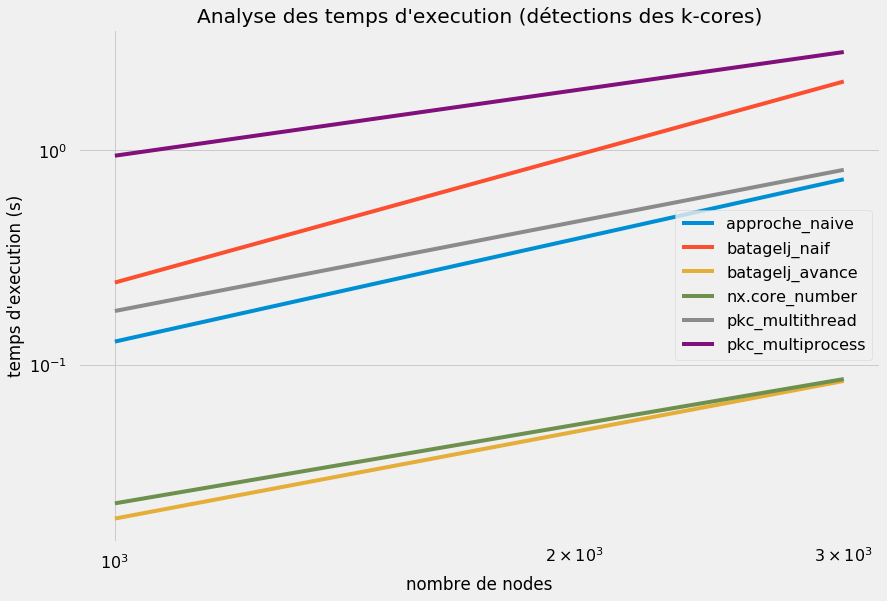

In [24]:
from matplotlib import pyplot as plt
import numpy as np


plt.style.use(['seaborn-poster','fivethirtyeight'])

# plt.style.use(['dark_background', 'presentation'])


fig, ax = plt.subplots()
for function,array in functions_arrays:
    ax.plot(x, array,label=function)

ax.set_title("Analyse des temps d'execution (détections des k-cores)")
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel ("nombre de nodes")
plt.ylabel ("temps d'execution (s)")
plt.show()